In [3]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [48]:
batch_size = 3

In [49]:
def sample_dataset(start, end, num_samples, noise):
     x = torch.linspace(start, end, num_samples)
     y = torch.linspace(start, end, num_samples)
     X, Y = torch.meshgrid(x, y)

     sample_mean = - torch.divide(1, 2*torch.pi**2) * torch.sin(torch.pi * X) * torch.cos(torch.pi * Y)
     sample_var = noise*np.ones_like(sample_mean)
     u = stats.norm(sample_mean, sample_var).rvs(random_state=444)

     return x, y, X, Y, u, sample_mean

In [50]:
# Parameters for the training dataset
num_samples = 16
noise = 0.005
start = 0.0
end = 1.0

# Generate the dataset
x, y, X, Y, u, sample_mean = sample_dataset(start, end, num_samples, noise)

In [51]:
print(X.flatten()[:5])
print(Y.flatten()[:5])
print(u.shape)
print(u.flatten().shape)
print(sample_mean.shape)

tensor([0., 0., 0., 0., 0.])
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667])
(16, 16)
(256,)
torch.Size([16, 16])


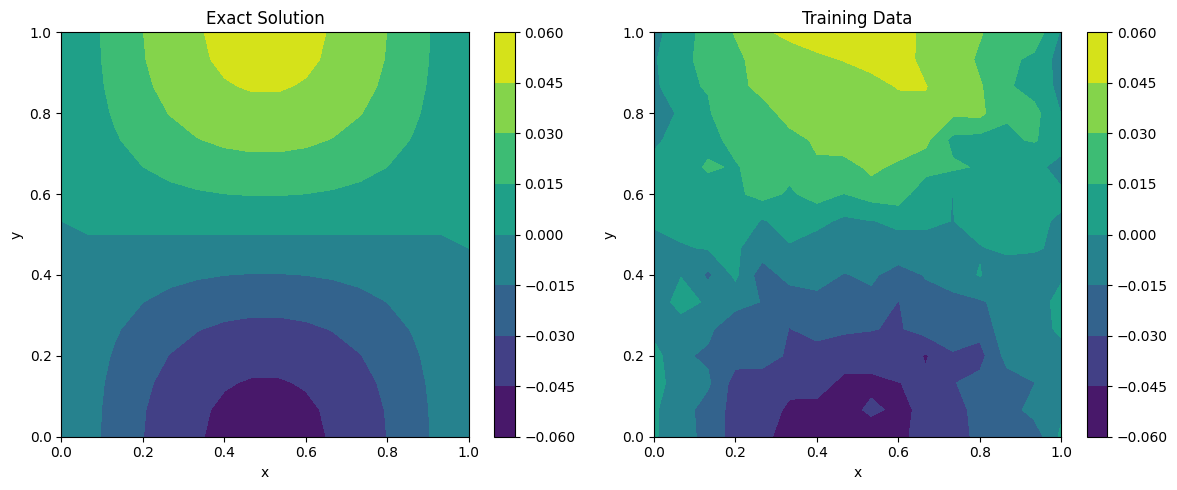

In [52]:
# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the solution and noisy data
contour_sol = axs[0].contourf(X, Y, sample_mean, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("Exact Solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X, Y, u, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Training Data")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

In [53]:
xy_train = torch.stack((X.flatten(), Y.flatten()), dim=1)
u_train = torch.Tensor(u.flatten()).unsqueeze(1)

train_dataset = TensorDataset(xy_train, u_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(xy_train[:5])
print(u_train[:5])
print(train_dataset[:5])

tensor([[0.0000, 0.0000],
        [0.0000, 0.0667],
        [0.0000, 0.1333],
        [0.0000, 0.2000],
        [0.0000, 0.2667]])
tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]])
(tensor([[0.0000, 0.0000],
        [0.0000, 0.0667],
        [0.0000, 0.1333],
        [0.0000, 0.2000],
        [0.0000, 0.2667]]), tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]]))


In [54]:
print(xy_train.shape)
print(u_train.shape)
print(f"First 5 xy_train entries:\n{xy_train[:5]}")
print(f"\nFirst 5 u values:\n{u_train[:5]}")
print(f"\nFirst 5 x values:\n{x[:5]}")
print(f"\nFirst 5 y values:\n{y[:5]}")

torch.Size([256, 2])
torch.Size([256, 1])
First 5 xy_train entries:
tensor([[0.0000, 0.0000],
        [0.0000, 0.0667],
        [0.0000, 0.1333],
        [0.0000, 0.2000],
        [0.0000, 0.2667]])

First 5 u values:
tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]])

First 5 x values:
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667])

First 5 y values:
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667])


In [55]:
class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()

        self.optimizer = None
        self.train_loss_history = []

        self.hidden_size = 15

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # weight initialization
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)


    def forward(self, x, y):  # Pass in x and y instead of t
        X,Y = torch.meshgrid(x,y)

        # Combine x and y along the last dimension
        xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        # Pass the combined input through the network
        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    def PDE_residual(self, x, y):
        u = self.forward(x, y)

        x.requires_grad=True
        y.requires_grad=True

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + torch.divide(1,2*torch.pi**2) * torch.cos(torch.pi*x)*torch.sin(torch.pi*y)  # Replace with your actual PDE Del^2 n - f

        return residual



    def loss_data(self, x, y, u): #update variables
        if isinstance(u, np.ndarray):
            u = torch.tensor(u).flatten().unsqueeze(1)

        u_pred = self.forward(x, y)
        u_pred = torch.tensor(u_pred, dtype=torch.float32)

        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data

    def loss_interior(self, num_samples=100): #uniform sampling x and y between [0,1] pass to PDE_residual
        x_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
        y_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
        res = self.PDE_residual(x_samples, y_samples)
        loss_residual = torch.mean(torch.square(res)) #like rms error
        return loss_residual

#    def loss_initial_condition(self):# No IC loss not time dependent
#        self.y0 = torch.zeros(1, 1)
#        self.x0 = torch.ones(1, 1)

#        bc_pred = self.forward(self.x0, self.y0)
#        loss_ic = torch.mean(torch.square(self.y0 - y0_pred))
#        return loss_ic

    def compute_losses(self):  # a simple wrapper
        loss_interior = self.loss_interior()
        loss_data = self.loss_data(x, y, u)
        return loss_interior, loss_data
        #return loss_interior, loss_data

    def closure(self, w1=1, w2=10):# update ... removed w1, w3
        self.optimizer.zero_grad()
        loss_interior, loss_data = self.compute_losses() # removed loss_ic and loss_data
        total_loss = w1 * loss_data + w2 * loss_interior    #removed w3 * loss_data
        total_loss.backward(retain_graph=True)
        return total_loss

# try to test in bits and pieces. plot results/outputs to sanity check. ie data_loss is working then etc. interior_loss

    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)

            if epoch % 1000 == 0:  # Set the printing frequency
                loss_interior, loss_data = self.compute_losses()     # removed loss_ic and loss_data
                total_loss = loss_interior + loss_data  #removed loss_ic + loss_data

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),  #removed loss_ic.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_data.cpu().detach().numpy()      #removed loss_data.cpu().detach().numpy()
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        loss_interior = np.split(loss_hist, 3, axis=1) #removed total_loss, loss_ic,loss_data
        return total_loss, loss_interior, loss_data   #removed loss_ic, loss_data

    def plot_losses(self):
            total_loss, loss_interior, loss_data = self.get_training_history()

            plt.figure(figsize=(12, 8))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), label='Total Loss')
            plt.legend()
            plt.title('Total Loss')

    #        plt.subplot(2, 2, 2)
    #        plt.plot(loss_ic, marker=MarkerStyle('o', fillstyle='none'), label='Initial Condition Loss')
    #        plt.legend()
    #        plt.title('Initial Condition Loss')

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), label='Interior Loss')
            plt.legend()
            plt.title('Interior Loss')

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), label='Data Loss')
            plt.legend()
            plt.title('Data Loss')

            plt.tight_layout()
            plt.show()

    def make_plot(self):
        # Get predictions
        u_pred = self.forward(x, y)

        # Create DataFrame from predictions
        data = {
            "x": list(x.squeeze().detach().numpy()),
            "y": list(y.squeeze().detach().numpy()),
            "u_pred": list(u_pred.squeeze().detach().numpy())
        }
        temp = pd.DataFrame.from_dict(data)

        # Pivot the DataFrame to create a grid for contour plotting
        grid_x, grid_y = np.meshgrid(
            np.unique(temp["x"]),
            np.unique(temp["y"])
        )
        grid_z = temp.pivot_table(index="y", columns="x", values="u_pred").values

        # Make the contour plot
        plt.figure(figsize=(8, 6))
        contour = plt.contour(grid_x, grid_y, grid_z, cmap='viridis')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Contour Plot of Predictions")
        plt.colorbar(contour)
        plt.show()

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward().to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=15, bias=True)
  (b2): Linear(in_features=15, out_features=15, bias=True)
  (b3): Linear(in_features=15, out_features=1, bias=True)
)
Params: 301


In [57]:
#print(model.forward(x.to(device),y.to(device)).shape) # Move x and y to the same device as the model
print(model.forward(x,y).shape) # Move x and y to the same device as the model
print(model.forward(x,y).dtype)

torch.Size([256, 1])
torch.float32


In [58]:
num_samples = 10
x_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
y_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
print(model.PDE_residual(x_samples, y_samples).shape)
print(model.PDE_residual(x_samples, y_samples))

torch.Size([10])
tensor([4.3530, 4.1571, 4.4239, 3.9195, 4.0957, 4.1752, 3.9852, 4.2845, 3.6357,
        4.2823], grad_fn=<AddBackward0>)


In [59]:
model.loss_interior()

tensor(1549.5161, grad_fn=<MeanBackward0>)

In [60]:
model.compute_losses()

(tensor(1585.2244, grad_fn=<MeanBackward0>),
 tensor(0.2664, dtype=torch.float64))

In [61]:
input, output = next(iter(train_loader))

In [62]:
model.train(50_000, lr=1e-4)

Epoch (Adam): 0, Total Loss: 1557.1554729291365
Epoch (Adam): 1000, Total Loss: 2.0640367996278166
Epoch (Adam): 2000, Total Loss: 0.3811253408087167
Epoch (Adam): 3000, Total Loss: 0.1858010540875508
Epoch (Adam): 4000, Total Loss: 0.23434932541467896
Epoch (Adam): 5000, Total Loss: 0.31060763062533575
Epoch (Adam): 6000, Total Loss: 0.34076484937503126
Epoch (Adam): 7000, Total Loss: 0.12131715292888937
Epoch (Adam): 8000, Total Loss: 0.11921452071190397
Epoch (Adam): 9000, Total Loss: 0.10938899980005815
Epoch (Adam): 10000, Total Loss: 0.11112203006149858
Epoch (Adam): 11000, Total Loss: 0.15443444423085956
Epoch (Adam): 12000, Total Loss: 0.11674979172714665
Epoch (Adam): 13000, Total Loss: 0.12418892184914836
Epoch (Adam): 14000, Total Loss: 0.12116710687207623
Epoch (Adam): 15000, Total Loss: 0.11810970915728644
Epoch (Adam): 16000, Total Loss: 0.1192073435027918
Epoch (Adam): 17000, Total Loss: 0.11804839221427227
Epoch (Adam): 18000, Total Loss: 0.12188463519278361
Epoch (Adam

In [63]:
model.plot_losses()

NameError: name 'total_loss' is not defined

(100, 100)
torch.Size([100, 100])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
        ...,
        [0.9798, 0.9798, 0.9798,  ..., 0.9798, 0.9798, 0.9798],
        [0.9899, 0.9899, 0.9899,  ..., 0.9899, 0.9899, 0.9899],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])
torch.Size([100, 100])
tensor([[0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
         0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
         0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
         0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
         0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
         0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
         0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.

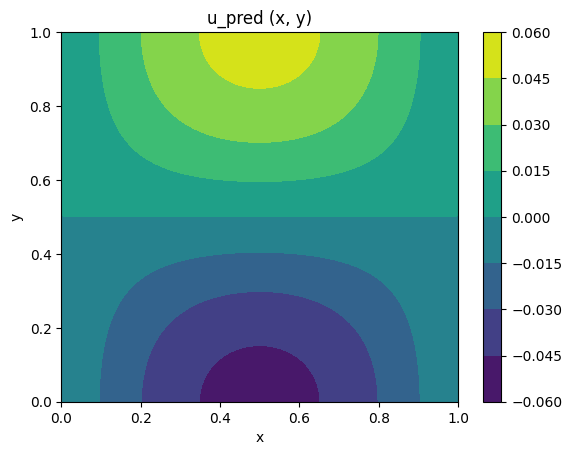

In [64]:
x_test, y_test, X_test, Y_test, u, sample_mean_test = sample_dataset(0.0, 1.0, 100, noise=0.0)
u_pred = model.forward(x_test, y_test)
u_pred = u_pred.detach().numpy()
u_pred = u_pred.reshape(len(x_test), len(y_test))

print(u_pred.shape)
print(X_test.shape)
print(X_test)
print(Y_test.shape)
print(Y_test[:1])

contour = plt.contourf(X_test, Y_test, sample_mean_test, cmap='viridis')

# Add a color bar to indicate the scale
plt.colorbar(contour)

# Label the axes
plt.xlabel("x")
plt.ylabel("y")
plt.title("u_pred (x, y)")

# Show the plot
plt.show()

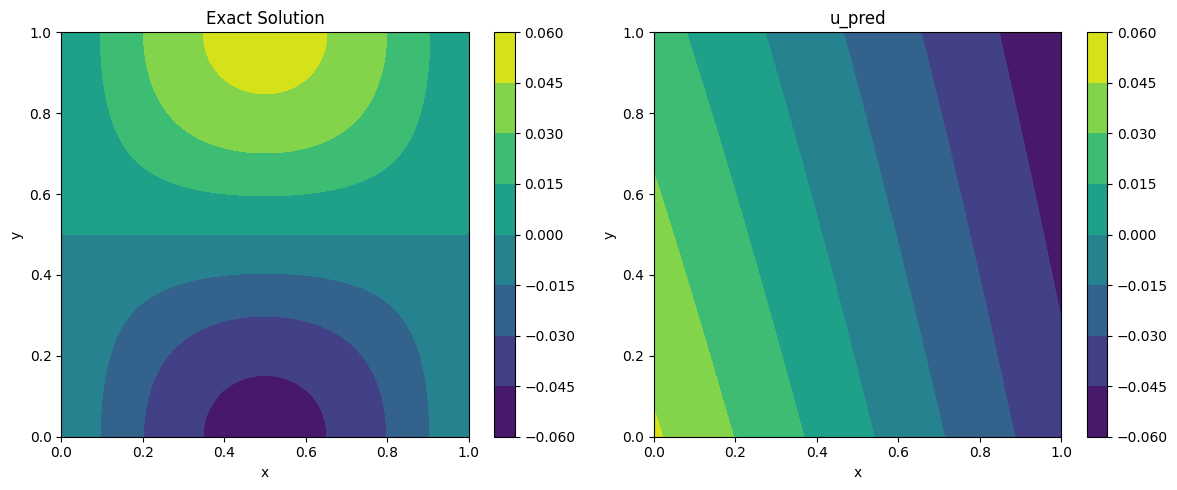

In [65]:
# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the solution and noisy data
contour_sol = axs[0].contourf(X_test, Y_test, sample_mean_test, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("Exact Solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X_test, Y_test, u_pred, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("u_pred")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()